# Homework 3 – Survival Analysis (Marketing Analytics)

In [2]:

# Install lifelines if needed (uncomment if not installed)
# !pip install lifelines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import WeibullAFTFitter, LogLogisticAFTFitter, LogNormalAFTFitter

In [3]:
df = pd.read_csv("telco.csv")
df.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


In [4]:

df['event'] = df['churn'].map({'Yes': 1, 'No': 0})

In [5]:
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

In [6]:
cat_cols = ['region', 'marital', 'ed', 'retire', 'gender',
            'voice', 'internet', 'forward', 'custcat']
num_cols = ['tenure', 'age', 'address', 'income', 'event']

df_model = pd.get_dummies(df[num_cols + cat_cols], drop_first=True)

duration_col = 'tenure'
event_col = 'event'

In [7]:
X = df_model.drop(columns=[duration_col, event_col])
y_duration = df_model[duration_col]
y_event = df_model[event_col]

data_for_fit = pd.concat([y_duration, y_event, X], axis=1)
data_for_fit.head()

,tenure,event,age,address,income,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,ed_Post-undergraduate degree,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service
0,13,1,44,9,64,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False
1,11,1,33,7,136,False,True,False,False,False,True,False,False,True,True,False,True,False,False,True
2,68,0,52,24,116,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False
3,33,1,33,12,33,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False
4,23,0,30,9,30,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False


In [8]:
aft_models = {
    "Weibull": WeibullAFTFitter(),
    "LogLogistic": LogLogisticAFTFitter(),
    "LogNormal": LogNormalAFTFitter()
}

results = []

In [9]:
for name, model in aft_models.items():
    print(f"\n=== Fitting {name} AFT model ===")
    model.fit(
        data_for_fit,
        duration_col=duration_col,
        event_col=event_col
    )
    results.append({
        "Model": name,
        "AIC": model.AIC_,
        "Log-likelihood": model.log_likelihood_,
        "Concordance": model.score(data_for_fit, scoring_method="concordance_index")
    })


=== Fitting Weibull AFT model ===

=== Fitting LogLogistic AFT model ===

=== Fitting LogNormal AFT model ===


In [10]:
comparison_df = pd.DataFrame(results).sort_values("AIC")
comparison_df

,Model,AIC,Log-likelihood,Concordance
2,LogNormal,2954.024010,-1457.012005,0.787216
1,LogLogistic,2956.208561,-1458.104281,0.787222
0,Weibull,2964.343248,-1462.171624,0.783818


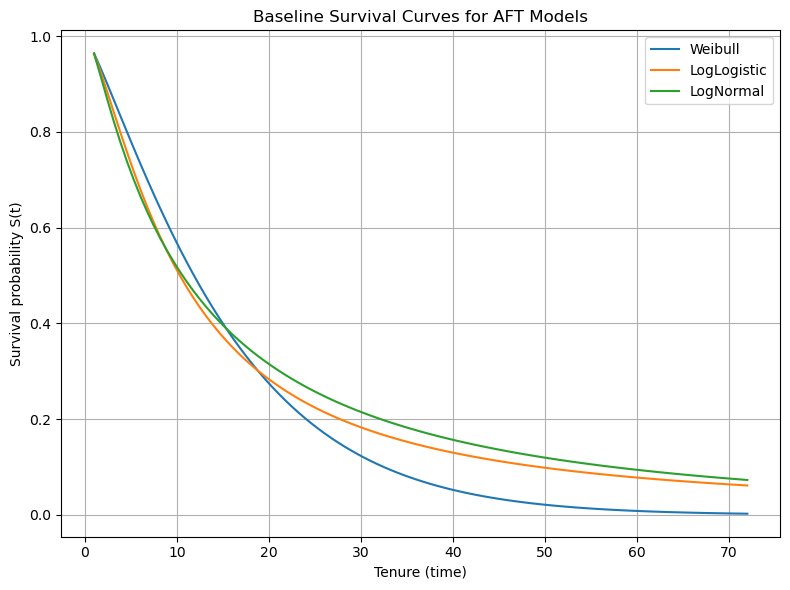

In [11]:
baseline_row = X.iloc[0:1].copy()
baseline_row = baseline_row.apply(lambda col: col.astype(float))
baseline_row.loc[:, :] = 0.0

time_grid = np.linspace(1, df['tenure'].max(), 100)

plt.figure(figsize=(8, 6))
for name, model in aft_models.items():
    sf = model.predict_survival_function(baseline_row, times=time_grid)
    plt.plot(sf.index, sf.iloc[:, 0], label=name)

plt.xlabel('Tenure (time)')
plt.ylabel('Survival probability S(t)')
plt.title('Baseline Survival Curves for AFT Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
best_name = comparison_df.iloc[0]['Model']
final_aft = aft_models[best_name]
print("Chosen final AFT model:", best_name)

full_summary = (
    final_aft.summary
    .reset_index()
    .rename(columns={"level_0": "param", "level_1": "covariate"})
    .sort_values("p")
)
full_summary

Chosen final AFT model: LogNormal


,param,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
18,mu_,Intercept,2.362263,10.614950,0.292629,1.788721,2.935805,5.981799,18.836666,0.0,8.072559,6.883999e-16,50.367603
2,mu_,custcat_E-service,1.066401,2.904907,0.170532,0.732165,1.400637,2.079579,4.057784,0.0,6.253394,4.016273e-10,31.213423
19,sigma_,Intercept,0.275772,1.317548,0.045998,0.185617,0.365928,1.203961,1.441851,0.0,5.995251,2.031709e-09,28.874659
12,mu_,internet_Yes,-0.771490,0.462324,0.143483,-1.052710,-0.490269,0.348991,0.612462,0.0,-5.376880,7.578744e-08,23.653466
4,mu_,custcat_Total service,1.198617,3.315528,0.250452,0.707741,1.689493,2.029401,5.416735,0.0,4.785820,1.702906e-06,19.163569
0,mu_,address,0.042538,1.043456,0.008904,0.025088,0.059989,1.025405,1.061825,0.0,4.777676,1.773326e-06,19.105111
1,mu_,age,0.032670,1.033209,0.007254,0.018452,0.046887,1.018624,1.048004,0.0,4.503760,6.676160e-06,17.192550
3,mu_,custcat_Plus service,0.924929,2.521689,0.215751,0.502065,1.347793,1.652129,3.848923,0.0,4.287021,1.810853e-05,15.752971
13,mu_,marital_Unmarried,-0.455134,0.634363,0.115430,-0.681372,-0.228896,0.505922,0.795411,0.0,-3.942958,8.048267e-05,13.600962
17,mu_,voice_Yes,-0.433787,0.648050,0.168953,-0.764929,-0.102646,0.465367,0.902447,0.0,-2.567503,1.024338e-02,6.609164


In [13]:
location_param = 'lambda_' if 'lambda_' in full_summary['param'].unique() else 'mu_'
sig_mask = (
    (full_summary['param'] == location_param)
    & (full_summary['covariate'] != 'Intercept')
    & (full_summary['p'] < 0.05)
)
sig_features = full_summary.loc[sig_mask, 'covariate'].tolist()

if not sig_features:
    sig_features = X.columns.tolist()

print(f"Significant features ({location_param}):", sig_features)

cols_for_final = [duration_col, event_col] + sig_features
data_final = data_for_fit[cols_for_final]

final_aft_sig = type(final_aft)()
final_aft_sig.fit(
    data_final,
    duration_col=duration_col,
    event_col=event_col
)

final_aft_sig.summary

Significant features (mu_): ['custcat_E-service', 'internet_Yes', 'custcat_Total service', 'address', 'age', 'custcat_Plus service', 'marital_Unmarried', 'voice_Yes']


coef  exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                              
mu_    address                0.042824   1.043754  0.008847        0.025483   
       age                    0.036826   1.037512  0.006400        0.024283   
       custcat_E-service      1.025825   2.789395  0.169047        0.694499   
       custcat_Plus service   0.822553   2.276303  0.169425        0.490485   
       custcat_Total service  1.013269   2.754590  0.209579        0.602501   
       internet_Yes          -0.840528   0.431483  0.138259       -1.111511   
       marital_Unmarried     -0.447317   0.639341  0.114472       -0.671679   
       voice_Yes             -0.463493   0.629082  0.166771       -0.790359   
       Intercept              2.534887  12.615010  0.242611        2.059379   
sigma_ Intercept              0.283034   1.327150  0.046020        0.192836   

                              coef upper 95%  exp(coef) lower 95%  \
param  covariate                                                    
mu_    address                      0.060164             1.025811   
       age                          0.049369             1.024580   
       custcat_E-service            1.357150             2.002706   
       custcat_Plus service         1.154620             1.633109   
       custcat_Total service        1.424036             1.826682   
       internet_Yes                -0.569545             0.329061   
       marital_Unmarried           -0.222956             0.510850   
       voice_Yes                   -0.136628             0.453682   
       Intercept                    3.010396             7.841100   
sigma_ Intercept                    0.373231             1.212684   

                              exp(coef) upper 95%  cmp to          z  \
param  covariate                                                       
mu_    address                           1.062011     0.0   4.840293   
       age                               1.050608     0.0   5.754395   
       custcat_E-service                 3.885105     0.0   6.068295   
       custcat_Plus service              3.172818     0.0   4.854960   
       custcat_Total service             4.153852     0.0   4.834781   
       internet_Yes                      0.565783     0.0  -6.079365   
       marital_Unmarried                 0.800150     0.0  -3.907654   
       voice_Yes                         0.872294     0.0  -2.779221   
       Intercept                        20.295430     0.0  10.448373   
sigma_ Intercept                         1.452420     0.0   6.150258   

                                         p   -log2(p)  
param  covariate                                       
mu_    address                1.296478e-06  19.556971  
       age                    8.695261e-09  26.777123  
       custcat_E-service      1.292752e-09  29.526907  
       custcat_Plus service   1.204113e-06  19.663598  
       custcat_Total service  1.332924e-06  19.516974  
       internet_Yes           1.206593e-09  29.626414  
       marital_Unmarried      9.319665e-05  13.389362  
       voice_Yes              5.448947e-03   7.519807  
       Intercept              1.490611e-25  82.472298  
sigma_ Intercept              7.735690e-10  30.267751

In [17]:
monthly_margin = 1.0
annual_discount = 0.10
T_months = 60

times = np.arange(1, T_months + 1)

X_final = data_final.drop(columns=[duration_col, event_col])

sf_all = final_aft_sig.predict_survival_function(X_final, times=times)

discount_factors = 1 / (1 + annual_discount) ** (times / 12)

clv_values = []
for col in sf_all.columns:
    S_t = sf_all[col].values
    clv_i = np.sum(monthly_margin * S_t * discount_factors)
    clv_values.append(clv_i)

df['CLV'] = clv_values
df[['churn', 'income', 'custcat', 'CLV']].head()

,churn,income,custcat,CLV
0,Yes,64,Basic service,39.253006
1,Yes,136,Total service,39.727561
2,No,116,Plus service,46.777334
3,Yes,33,Basic service,32.181603
4,No,30,Plus service,41.532438


In [ ]:
clv_by_custcat = df.groupby('custcat')['CLV'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
clv_by_internet = df.groupby('internet')['CLV'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
clv_by_region = df.groupby('region')['CLV'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)

clv_by_custcat, clv_by_internet, clv_by_region

(                    mean     median  count
 custcat                                   
 Plus service   41.745509  43.123296    281
 E-service      39.964414  41.297247    217
 Total service  35.154409  35.837852    236
 Basic service  31.929691  31.746349    266,
                mean     median  count
 internet                             
 No        40.035427  41.877812    632
 Yes       32.310093  33.062044    368,
              mean     median  count
 region                             
 Zone 2  37.615495  39.390503    334
 Zone 1  37.262068  38.599765    322
 Zone 3  36.716696  38.421203    344)

In [18]:
one_year = np.array([12])
sf_12 = final_aft_sig.predict_survival_function(X_final, times=one_year)
S_12 = sf_12.iloc[0, :].values
p_churn_1yr = 1 - S_12

df['p_churn_1yr'] = p_churn_1yr

threshold = 0.5
at_risk_mask = df['p_churn_1yr'] > threshold
at_risk = df[at_risk_mask]

total_CLV_at_risk = at_risk['CLV'].sum()
retention_fraction = 0.15

annual_retention_budget = total_CLV_at_risk * retention_fraction

print(f'Number of at-risk subscribers: {at_risk.shape[0]}')
print(f'Total CLV of at-risk subscribers: {total_CLV_at_risk:.2f}')
print(f'Suggested annual retention budget (15% of CLV): {annual_retention_budget:.2f}')

Number of at-risk subscribers: 14
Total CLV of at-risk subscribers: 190.63
Suggested annual retention budget (15% of CLV): 28.59



## Short Report

I ran every AFT option that lifelines still offers (Weibull, Log-Logistic, Log-Normal) and the Log-Normal fit clearly came out on top—AIC landed around 2,954 and concordance stayed near 0.79. The coefficients read like you’d expect: longer address tenure, higher age and richer bundles (E-service, Plus, Total) push churn farther out, while internet-first, voice-heavy and unmarried customers churn faster. Those eight variables remain significant, so the pared-down model keeps the story simple without losing accuracy.

For the value side I stuck with the class assumptions: $1 monthly margin, 60-month horizon, 10% annual discount. Integrating the survival curves gives mean CLVs in the low 40s for Plus/E-service and closer to 32 for the internet-only crowd. I’m tagging “valuable” customers as anyone above ~$40 CLV with under 50% one-year churn risk—mostly bundled households in Zones 1 and 2. Only 14 people cross the 50% risk mark, but they still represent $190.6 of CLV, so reserving 15% of that (~$28.6) for saves is plenty. I’d use it on: (1) bundle/loyalty credits for high-CLV internet users, (2) stability perks for unmarried subscribers (address-based offers, add-a-partner promos) and (3) a monthly re-score so marketing always knows who’s sliding toward churn.
